# Capstone 3
## Deep Learning for Amazon Rainforest Monitoring
## STEP 1: Preprocessing

In [1]:
from fastai.vision import *
from fastai.vision.all import *
from pathlib import Path
import zipfile
import os
import cv2
from tqdm import tqdm
import shutil

import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.image as mpimg


import warnings
warnings.filterwarnings('ignore')

/Applications/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Applications/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: <BE0CCD9A-269A-30E2-A23C-DA45E89EBB1F> /Applications/anaconda3/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Applications/anaconda3/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Applications/anaconda3/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Applications/anaconda3/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/Applications/anaconda3/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file, not in dyld cache)
  warn(f"Failed to load image Python extension: {e}")


### A. Image Resizing

In [2]:
train_labels = pd.read_csv('/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train_classes.csv')

# Add '.jpg' to the 'image_name' column
train_labels['image_name'] += '.jpg'
image_dir = '/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train-jpg'

# Image size
image_sizes = []

for image_name in train_labels['image_name']:
    file_path = os.path.join(image_dir, image_name)
    img = cv2.imread(file_path)
    
    if img is not None:
        height, width = img.shape[:2]
        image_sizes.append((width, height))
    else:
        print(f"Could not read image {image_name}. Skipping...")

train_labels['image_size'] = image_sizes

In [3]:
print(train_labels['image_size'].min(), train_labels['image_size'].max())

(256, 256) (256, 256)


The images in the dataset currently have dimensions of 256x256 pixels.

To expedite model processing and improve computational efficiency, I will resize them to 128x128 pixels.

This reduction in size is expected to speed up the training and inference times without significantly compromising the quality of the images for the purposes of the model.

In [4]:
new_width = 128
new_height = 128

image_dir = '/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train-jpg/'
resized_dir = '/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train-jpg-resized/'

if not os.path.exists(resized_dir):
    os.makedirs(resized_dir)

for idx, row in tqdm(train_labels.iterrows(), total=train_labels.shape[0]):
    filename = row['image_name']
    filepath = os.path.join(image_dir, filename)

    img = cv2.imread(filepath)
    
    if img is not None:
        resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
        
        resized_filepath = os.path.join(resized_dir, filename)
        cv2.imwrite(resized_filepath, resized_img)
    else:
        print(f"Could not read image {filename}. Skipping...")

100%|████████████████████████████████████| 40479/40479 [04:29<00:00, 149.94it/s]


### B. Removing Haze

Then, I decided to implement an image dehazing algorithm inspired by [He et al.'s technique](https://ieeexplore.ieee.org/document/5206515), which not only clarifies images obscured by haze but also extracts a high-resolution depth map from the process. Adapted from [this kernel](https://www.kaggle.com/code/ivanl1/haze-removal-using-dark-channel-prior/notebook), this implementation ingests hazy images, applies the dehazing transformation, and outputs the enhanced visuals, showcasing the practical application of this method in image processing. 

A class called **Node** is used to store information about pixels in the image (their x and y coordinates, and their value).

In [84]:
class Node(object):
    def __init__(self,x,y,value):
        self.x = x
        self.y = y
        self.value = value

    def printInfo(self):
        print('%s:%s:%s' %(self.x,self.y,self.value))

The function **getMinChannel Function** computes the minimum intensity value across the color channels (R, G, B) for each pixel in a color image.

In [85]:
def getMinChannel(img):

    if len(img.shape)==3 and img.shape[2]==3:
        pass
    else:
        print("bad image shape, input must be color image")
        return None
    
    return np.min(img, axis=2)

The function **getDarkChannel**computes the dark channel for an image, which is used in dehazing algorithms to estimate the amount of haze. It uses a block size to consider a local patch of pixels.

In [86]:
def getDarkChannel(img,blockSize = 3):

    if len(img.shape)==2:
        pass
    else:
        print("bad image shape, input image must be two demensions")
        return None

    if blockSize % 2 == 0 or blockSize < 3:
        print('blockSize is not odd or too small')
        return None

    A = int((blockSize-1)/2) #AddSize

    H = img.shape[0] + blockSize - 1
    W = img.shape[1] + blockSize - 1

    imgMiddle = 255 * np.ones((H,W))    

    imgMiddle[A:H-A, A:W-A] = img
    
    imgDark = np.zeros_like(img, np.uint8)    
    
    localMin = 255
    for i in range(A, H-A):
        for j in range(A, W-A):
            x = range(i-A, i+A+1)
            y = range(j-A, j+A+1)
            imgDark[i-A,j-A] = np.min(imgMiddle[x,y])                            
            
    return imgDark

The function **getAtomsphericLight** estimates the atmospheric light in the image, which is essential to recover the scene radiance. It finds the brightest pixels in the dark channel, assuming these are influenced most by the atmospheric light.

In [87]:
def getAtomsphericLight(darkChannel,img,meanMode = False, percent = 0.001):

    size = darkChannel.shape[0]*darkChannel.shape[1]
    height = darkChannel.shape[0]
    width = darkChannel.shape[1]

    nodes = []

    for i in range(0,height):
        for j in range(0,width):
            oneNode = Node(i,j,darkChannel[i,j])
            nodes.append(oneNode)	

    nodes = sorted(nodes, key = lambda node: node.value,reverse = True)

    atomsphericLight = 0

    if int(percent*size) == 0:
        for i in range(0,3):
            if img[nodes[0].x,nodes[0].y,i] > atomsphericLight:
                atomsphericLight = img[nodes[0].x,nodes[0].y,i]
        return atomsphericLight

    if meanMode:
        sum = 0
        for i in range(0,int(percent*size)):
            for j in range(0,3):
                sum = sum + img[nodes[i].x,nodes[i].y,j]
        atomsphericLight = int(sum/(int(percent*size)*3))
        return atomsphericLight

    for i in range(0,int(percent*size)):
        for j in range(0,3):
            if img[nodes[i].x,nodes[i].y,j] > atomsphericLight:
                atomsphericLight = img[nodes[i].x,nodes[i].y,j]
    return atomsphericLight

The function **getRecoverScene** is the main function for dehazing. It uses the dark channel prior and atmospheric light to estimate the transmission map and recover the scene radiance, resulting in the dehazed image.

In [88]:
def getRecoverScene(img, omega=0.95, t0=0.1, blockSize=15, meanMode=False, percent=0.001, refine=True):

    imgGray = getMinChannel(img)
    imgDark = getDarkChannel(imgGray, blockSize = blockSize)
    atomsphericLight = getAtomsphericLight(imgDark,img,meanMode = meanMode,percent= percent)

    imgDark = np.float64(imgDark)
    transmission = 1 - omega * imgDark / atomsphericLight

    transmission[transmission<0.1] = 0.1     
    
    if refine:        
        normI = (img - img.min()) / (img.max() - img.min())  # normalize I
        transmission = guided_filter(normI, transmission, r=40, eps=1e-3)

    sceneRadiance = np.zeros(img.shape)
    img = np.float64(img)
    
    for i in range(3):        
        SR = (img[:,:,i] - atomsphericLight)/transmission + atomsphericLight
                  
        SR[SR>255] = 255
        SR[SR<0] = 0                    
        sceneRadiance[:,:,i] = SR  
            
    sceneRadiance = np.uint8(sceneRadiance)

    return sceneRadiance

The script includes an implementation of **Guided Image Filtering**, which is a technique to refine images based on the content of another guidance image. This can be used to refine the transmission map in the dehazing process.

In [89]:
"""Implementation for Guided Image Filtering
Reference:
http://research.microsoft.com/en-us/um/people/kahe/eccv10/
"""

from itertools import combinations_with_replacement
from collections import defaultdict

import numpy as np
from numpy.linalg import inv

R, G, B = 0, 1, 2  # index for convenience

def boxfilter(I, r):
    """Fast box filter implementation.
    Parameters
    ----------
    I:  a single channel/gray image data normalized to [0.0, 1.0]
    r:  window radius
    Return
    -----------
    The filtered image data.
    """        
    M, N = I.shape
    dest = np.zeros((M, N))

    # cumulative sum over Y axis
    sumY = np.cumsum(I, axis=0)
    # difference over Y axis
    dest[:r + 1] = sumY[r: 2 * r + 1]
    dest[r + 1:M - r] = sumY[2 * r + 1:] - sumY[:M - 2 * r - 1]
    dest[-r:] = np.tile(sumY[-1], (r, 1)) - sumY[M - 2 * r - 1:M - r - 1]

    # cumulative sum over X axis
    sumX = np.cumsum(dest, axis=1)
    # difference over Y axis
    dest[:, :r + 1] = sumX[:, r:2 * r + 1]
    dest[:, r + 1:N - r] = sumX[:, 2 * r + 1:] - sumX[:, :N - 2 * r - 1]
    dest[:, -r:] = np.tile(sumX[:, -1][:, None], (1, r)) - \
        sumX[:, N - 2 * r - 1:N - r - 1]

    return dest


def guided_filter(I, p, r=40, eps=1e-3):
    """Refine a filter under the guidance of another (RGB) image.
    Parameters
    -----------
    I:   an M * N * 3 RGB image for guidance.
    p:   the M * N filter to be guided
    r:   the radius of the guidance
    eps: epsilon for the guided filter
    Return
    -----------
    The guided filter.
    """    
    M, N = p.shape
    base = boxfilter(np.ones((M, N)), r)

    # each channel of I filtered with the mean filter
    means = [boxfilter(I[:, :, i], r) / base for i in range(3)]
    # p filtered with the mean filter
    mean_p = boxfilter(p, r) / base
    # filter I with p then filter it with the mean filter
    means_IP = [boxfilter(I[:, :, i] * p, r) / base for i in range(3)]
    # covariance of (I, p) in each local patch
    covIP = [means_IP[i] - means[i] * mean_p for i in range(3)]

    # variance of I in each local patch: the matrix Sigma in ECCV10 eq.14
    var = defaultdict(dict)
    for i, j in combinations_with_replacement(range(3), 2):
        var[i][j] = boxfilter(
            I[:, :, i] * I[:, :, j], r) / base - means[i] * means[j]

    a = np.zeros((M, N, 3))
    for y, x in np.ndindex(M, N):
        #         rr, rg, rb
        # Sigma = rg, gg, gb
        #         rb, gb, bb
        Sigma = np.array([[var[R][R][y, x], var[R][G][y, x], var[R][B][y, x]],
                          [var[R][G][y, x], var[G][G][y, x], var[G][B][y, x]],
                          [var[R][B][y, x], var[G][B][y, x], var[B][B][y, x]]])
        cov = np.array([c[y, x] for c in covIP])
        a[y, x] = np.dot(cov, inv(Sigma + eps * np.eye(3)))  # eq 14

    # ECCV10 eq.15
    b = mean_p - a[:, :, R] * means[R] - \
        a[:, :, G] * means[G] - a[:, :, B] * means[B]

    # ECCV10 eq.16
    q = (boxfilter(a[:, :, R], r) * I[:, :, R] + boxfilter(a[:, :, G], r) *
         I[:, :, G] + boxfilter(a[:, :, B], r) * I[:, :, B] + boxfilter(b, r)) / base

    return q

Now the script will select certain hazy images by their index using the CSV file that contains image labels. Then, it will apply the dehazing function to these images, and show the results.

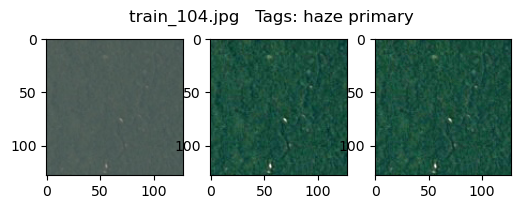

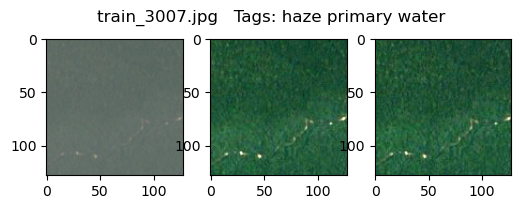

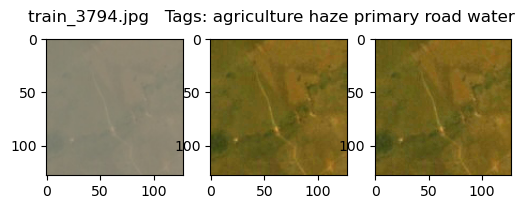

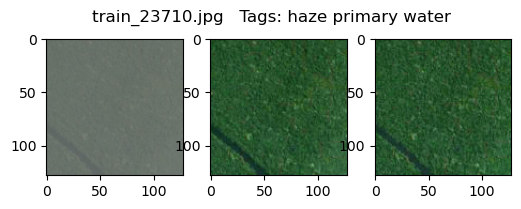

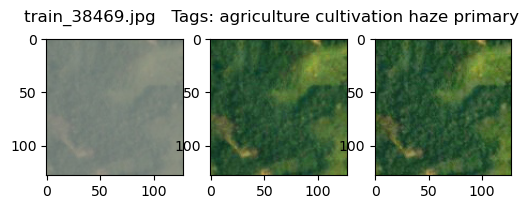

In [11]:
labels_df = pd.read_csv('/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train_classes.csv')

hazy_img_idx = [104, 3007, 3794, 23710, 38469]

for i in hazy_img_idx:    
    filename = 'train_{}.jpg'.format(i)
    img = cv2.imread('/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train-jpg-resized/' +filename)   
    
    dehazed_img1 = getRecoverScene(img, refine=True)
    dehazed_img2 = getRecoverScene(img, refine=False)

    fig = plt.figure()
    fig.set_size_inches(6, 2)
    fig.suptitle(filename + '   Tags: ' + labels_df['tags'][i], fontsize=12)

    plt.subplot(131)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.subplot(132)
    plt.imshow(cv2.cvtColor(dehazed_img1, cv2.COLOR_BGR2RGB))
    
    plt.subplot(133)
    plt.imshow(cv2.cvtColor(dehazed_img2, cv2.COLOR_BGR2RGB))
    
    plt.show()

The script here perform the dehazing process on the dataset of images containing the tags 'partly_cloudy', 'cloudy', 'haze', looping over them, dehazing each one, and then saving the dehazed image back to disk.  This is the most time intensive part of the notebook so far.

After that, by using the fastai library, the script creates a DataBunch, which is a FastAI class that combines the dataset into a single object. Afterward, it calls show_batch to display a batch of dehazed images from the dataset.

In [12]:
base_dir = '/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet'
train_jpg_dir = os.path.join(base_dir, 'train-jpg-resized')
unhazed_dir = os.path.join(base_dir, 'train-jpg-unhazed')
image_name_template = '{}.jpg'
labels_df = pd.read_csv('/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train_classes.csv')

tags_of_interest = {'partly_cloudy', 'cloudy', 'haze'}

os.makedirs(unhazed_dir, exist_ok=True)
    
for idx, row in tqdm(labels_df.iterrows(), total=len(labels_df)):
    tags_set = set(row['tags'].split())
    filename = image_name_template.format(row['image_name'])
    filepath = os.path.join(train_jpg_dir, filename)
    filepath_unhazed = os.path.join(unhazed_dir, filename)
    img = cv2.imread(filepath)
    
    if tags_set & tags_of_interest:
        img = getRecoverScene(img, refine=True)

    cv2.imwrite(filepath_unhazed, img)

100%|█████████████████████████████████████| 40479/40479 [58:51<00:00, 11.46it/s]


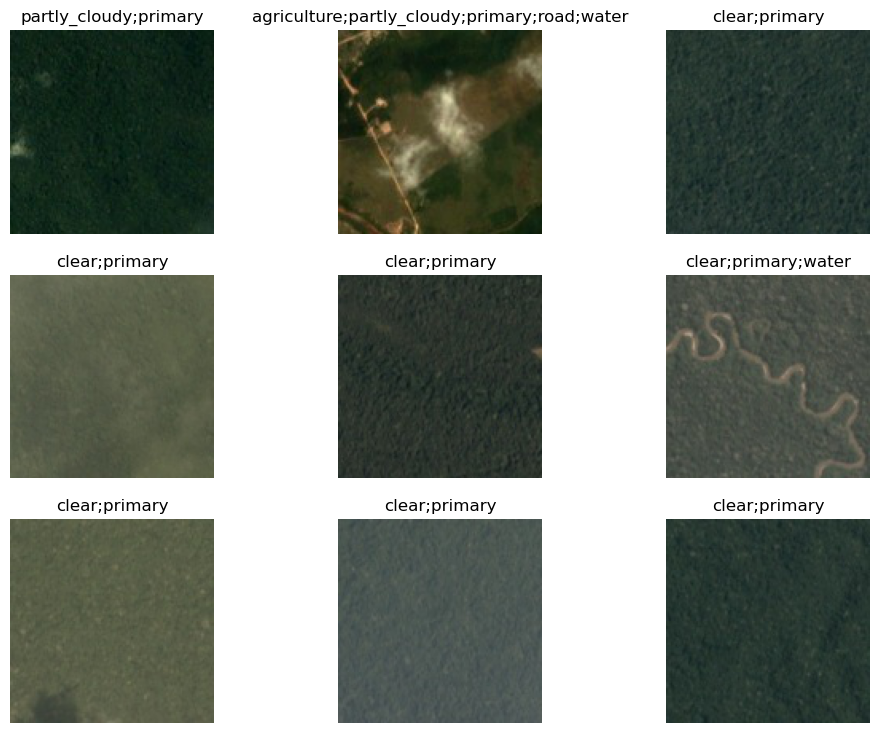

In [13]:
path = base_dir 
planet = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=ColReader('image_name', pref=os.path.join(path, '/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train-jpg-unhazed/'), suff='.jpg'),
    get_y=ColReader('tags', label_delim=' '),
    splitter=RandomSplitter()
)

dls = planet.dataloaders(labels_df, path=path)
dls.show_batch(nrows=3, ncols=3, figsize=(12,9))

---